In [1]:
import pandas as pd
#from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from IPython.display import display
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#from torch.utils.data import DataLoader
import torch
from transformers import BertConfig, BertForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.quantization import quantize_dynamic

c:\Users\denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Считывание датасетов и их анализ
data_train_open = open('../data/rusentiment_preselected_posts.csv', 'r', encoding='utf-8')
data_test_open = open('../data/rusentiment_test.csv', 'r', encoding='utf-8')

df_train = pd.read_csv(data_train_open)
df_test = pd.read_csv(data_test_open)

print(f'Размер train: {len(df_train)}')
print(f'Размер test: {len(df_test)}\n')

print(f'Пустые строки в train:\n {df_train.isnull().sum()}\n')
print(f'Пустые строки в test:\n {df_test.isnull().sum()}\n')

print(f"Пропуски в train: {df_train['label'].isnull().sum()}")
print(f"Пропуски в val: {df_test['label'].isnull().sum()}\n")

print(f'Дублированные строки в train: {df_train.duplicated().sum()}')
print(f'Дублированные строки в test: {df_test.duplicated().sum()}\n')

df_val, df_train = train_test_split(
    df_train, 
    test_size=0.85,
    train_size = 0.15,
    random_state=42,
    stratify=df_train['label']
)

train_sentiments = df_train['label'].tolist()
train_counts = Counter(train_sentiments)

test_sentiments = df_test['label'].tolist()
test_counts = Counter(test_sentiments)

val_sentiments = df_val['label'].tolist()
val_counts = Counter(val_sentiments)

print(f'Количество по категориям в train {train_counts}')
print(f'Количество по категориям в test {test_counts}')
print(f'Количество по категориям в val {val_counts}\n')

print('Тренировочные данные')
display(df_train)
print('Тестовые данные')
display(df_test)
print('Валидационные данные')
display(df_val)

Размер train: 6950
Размер test: 2967

Пустые строки в train:
 label    0
text     0
dtype: int64

Пустые строки в test:
 label    0
text     0
dtype: int64

Пропуски в train: 0
Пропуски в val: 0

Дублированные строки в train: 0
Дублированные строки в test: 0

Количество по категориям в train Counter({'neutral': 2531, 'positive': 1254, 'negative': 1156, 'skip': 768, 'speech': 199})
Количество по категориям в test Counter({'neutral': 1420, 'positive': 536, 'speech': 407, 'skip': 346, 'negative': 258})
Количество по категориям в val Counter({'neutral': 446, 'positive': 221, 'negative': 204, 'skip': 136, 'speech': 35})

Тренировочные данные


,label,text
3279,skip,"А мне - простой девушке, много не надо..... вл..."
469,neutral,"Вроде как о нежности, а на самом деле о МЯСЕ...."
1305,negative,"Объясните, огрызаться на каждую твою фразу - э..."
1903,negative,когда же покажут нормальные игры(
56,negative,Скоропостижно скончался американский музыкант ...
...,...,...
3535,negative,"[id38455195|Николай], это он русичам говорил. ..."
6291,neutral,"Слоник мы в геленджике, давай к нам !)))"
6888,neutral,я промолчу!!
6547,neutral,Федю завтра ждем:-)


Тестовые данные


,label,text
0,neutral,"Александр, тебе к лицу эта пушка :)\n"
1,positive,"Скоро ты вернешься домой, грязный, не бритый н..."
2,neutral,помниш...))
3,skip,Мы просто с [id12210212|Елисеем] психанули )...
4,speech,"ой, прости забыла поздравить, с праздничьком, ..."
...,...,...
2962,neutral,Коллективно жмём F13! И наблюдаем за результатом!
2963,neutral,ану ка быстро цоя добавь!
2964,skip,Ты одна половинка - я вторая половинка...... А...
2965,positive,Люблю кису)))


Валидационные данные


,label,text
2439,neutral,Любовь - это наркотик. Поначалу возникает эйфо...
5604,neutral,"Истинно мужской ответ - стоя посреди бардака, ..."
98,negative,скучно!!!!
1642,negative,"ну хули ты танцор ебать,пиздуй на район уже к ..."
6930,neutral,Милая моя! Солнышко радная Передай это 15 дево...
...,...,...
6772,positive,Так злобная моя карапузня я в тебя верю)))ты у...
5311,skip,Хорошо вам повисеть*
4498,positive,Любимый мульт в детстве) это была единственная...
3626,positive,:* уже лучше)


In [3]:
# Загружаем модель rubert-tiny2 и её токенизатор. Модель адаптируется для классификации текстов на 5 классов тональности. 
# Текстовые метки заменяются индикаторами во всех выборках.
# Метки преобразуются в тензоры. Подготовлены тензоры для train, validation и test
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=5
)

train_encodings = tokenizer(
    df_train['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

val_encodings = tokenizer(
    df_val['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2,
    'skip': 3,
    'speech': 4
}

df_train['label_num'] = df_train['label'].map(label_mapping)
df_val['label_num'] = df_val['label'].map(label_mapping)
df_test['label_num'] = df_test['label'].map(label_mapping)

train_labels = torch.tensor(df_train['label_num'].values, dtype=torch.long)
val_labels = torch.tensor(df_val['label_num'].values, dtype=torch.long)
test_labels = torch.tensor(df_test['label_num'].values, dtype=torch.long)

Loading weights: 100%|██████████| 55/55 [00:00<00:00, 685.85it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: cointegrated/rubert-tiny2
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/archit

In [4]:
# Модель обучается 5 эпох на тренировочных данных с шагом 5e-6, можно сделать шаг меньше для более лучших результатов. После каждой эпохи вычисляется точность на валидационных данных. Сохраняется лучшая модель. 
# В самом конце лучшая модель и токенизатор сохраняются

best_val_accuracy = 0
best_model_state = None

optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=5e-6) 
count_epoch = 5
for epoch in range(count_epoch):
    all_loss = 0
    teacher_model.train()
    for i in range(0, len(df_train), 16):
        batch_index = slice(i, i+16)        
        input_ids = train_encodings['input_ids'][batch_index]
        attention_mask = train_encodings['attention_mask'][batch_index]
        labels = train_labels[batch_index]
        
        optimizer.zero_grad()
        
        outputs = teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        all_loss += loss.item()

    print(f"Эпоха {epoch+1}, loss: {all_loss:.2f}")


    teacher_model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for i in range(0, len(df_val), 16):
            batch_index = slice(i, i+16)            
            input_ids = val_encodings['input_ids'][batch_index]
            attention_mask = val_encodings['attention_mask'][batch_index]
            labels = val_labels[batch_index]
            
            outputs = teacher_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            predictions = torch.argmax(outputs.logits, dim=1)            
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_true_labels, all_predictions) * 100
    
    print(f"Val accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = teacher_model.state_dict().copy()
        print(f"Лучший результат, сохранение модели\n")

teacher_model.load_state_dict(best_model_state)
print(f"Лучшее: {best_val_accuracy:.2f}%")

teacher_model.save_pretrained("teacher_model")
tokenizer.save_pretrained("teacher_model")

print("teacher обучен и сохранен")

Эпоха 1, loss: 543.93
Val accuracy: 42.80%
Лучший результат, сохранение модели

Эпоха 2, loss: 497.80
Val accuracy: 44.05%
Лучший результат, сохранение модели

Эпоха 3, loss: 470.09
Val accuracy: 47.98%
Лучший результат, сохранение модели

Эпоха 4, loss: 439.38
Val accuracy: 50.96%
Лучший результат, сохранение модели

Эпоха 5, loss: 413.43
Val accuracy: 53.45%
Лучший результат, сохранение модели

Лучшее: 53.45%


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

teacher обучен и сохранен


In [5]:
#Токенизируются тестовые тексты, вычисляется итоговая точность модели на тестовых данных, выводятся метрики 

test_encodings = tokenizer(
    df_test['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

teacher_model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for i in range(0, len(df_test), 16):
        batch_index = slice(i, min(i+16, len(df_test)))
        
        input_ids = test_encodings['input_ids'][batch_index]
        attention_mask = test_encodings['attention_mask'][batch_index]
        labels = test_labels[batch_index]
        
        outputs = teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        predictions = torch.argmax(outputs.logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_true_labels, all_predictions) * 100
print(f"test accuracy: {test_accuracy:.2f}%\n")

print(classification_report(all_true_labels, all_predictions))

test accuracy: 54.57%

              precision    recall  f1-score   support

           0       0.42      0.25      0.32       258
           1       0.65      0.86      0.74      1420
           2       0.35      0.59      0.44       536
           3       0.47      0.06      0.10       346
           4       0.71      0.01      0.02       407

    accuracy                           0.55      2967
   macro avg       0.52      0.35      0.32      2967
weighted avg       0.56      0.55      0.48      2967



In [6]:
#Создание функции, которая принимает список нового текста и предсказывает его тональность и вероятность каждой тональности
def predict_new_data(texts, model, tokenizer, batch_size=16):
    model.eval()
    predictions = []
    probabilities = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors='pt'
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    return predictions, probabilities

test_texts = test_texts = [  
    "Это лучший фильм, который я видел за последние годы!",
    "Отличная работа, ребята! Вы молодцы!",
    "Спасибо большое за помощь, вы меня спасли!",
    "Это ужасный продукт, никогда больше не куплю",
    "Сервис отвратительный, жалуюсь в прокуратуру",
    "Разочарован, деньги на ветер",
]

preds, probs = predict_new_data(test_texts, teacher_model, tokenizer)

for text, pred, prob in zip(test_texts, preds, probs):
    if pred == 0:
        sentiment = "НЕГАТИВНЫЙ"
    elif pred == 1:
        sentiment = "НЕЙТРАЛЬНЫЙ"
    elif pred == 2:
        sentiment = "ПОЗИТИВНЫЙ"
    elif pred == 3:
        sentiment = "ПРОПУСК"
    elif pred == 4:
        sentiment = "РЕЧЬ"


#label_mapping = {
#    'negative': 0,
#    'neutral': 1,
#    'positive': 2,
#    'skip': 3,
#    'speech': 4
#}

    confidence = prob[pred] * 100
    print(text)
    print(f"{sentiment} (предсказание: {confidence}%)")
    print(f"Вероятности: позитивный={prob[2]*100:.1f}%, нейтральный={prob[1]*100:.1f}%, негативный={prob[0]*100:.1f}%, пропуск={prob[3]*100:.1f}%, речь={prob[4]*100:.1f}%\n")

Это лучший фильм, который я видел за последние годы!
ПОЗИТИВНЫЙ (предсказание: 54.226844787597656%)
Вероятности: позитивный=54.2%, нейтральный=25.2%, негативный=6.3%, пропуск=7.1%, речь=7.3%

Отличная работа, ребята! Вы молодцы!
ПОЗИТИВНЫЙ (предсказание: 57.22966003417969%)
Вероятности: позитивный=57.2%, нейтральный=7.9%, негативный=5.9%, пропуск=9.6%, речь=19.3%

Спасибо большое за помощь, вы меня спасли!
РЕЧЬ (предсказание: 40.15209197998047%)
Вероятности: позитивный=36.3%, нейтральный=6.3%, негативный=6.4%, пропуск=10.8%, речь=40.2%

Это ужасный продукт, никогда больше не куплю
НЕЙТРАЛЬНЫЙ (предсказание: 55.47382354736328%)
Вероятности: позитивный=5.2%, нейтральный=55.5%, негативный=29.3%, пропуск=8.5%, речь=1.5%

Сервис отвратительный, жалуюсь в прокуратуру
НЕГАТИВНЫЙ (предсказание: 44.55787658691406%)
Вероятности: позитивный=6.8%, нейтральный=29.3%, негативный=44.6%, пропуск=16.6%, речь=2.7%

Разочарован, деньги на ветер
НЕЙТРАЛЬНЫЙ (предсказание: 56.338924407958984%)
Вероятности:

In [7]:
#Сокращение конфигураций модели (перед дисциляцией)
teacher_config = teacher_model.config

student_config = BertConfig(
    vocab_size=teacher_config.vocab_size,
    hidden_size=256,                    #Было 312
    num_hidden_layers=2,                #Было 3
    num_attention_heads=8,              #Было 12
    intermediate_size=1024,             #Было 1248
    num_labels=5,                       #Остается 5 классов
    max_position_embeddings=teacher_config.max_position_embeddings
)

student_model = BertForSequenceClassification(student_config)

print(f"Сравнение по размерам:")
print(f"teacher параметров: {sum(p.numel() for p in teacher_model.parameters())}")
print(f"student параметров: {sum(p.numel() for p in student_model.parameters())}")
print(f"Сжатие: {sum(p.numel() for p in teacher_model.parameters()) / sum(p.numel() for p in student_model.parameters()):.1f}")

Сравнение по размерам:
teacher параметров: 29195333
student параметров: 23631877
Сжатие: 1.2


In [8]:
#Проведение дисциляции, сохранение модели Student

def distillation_loss(student_logits, teacher_logits, labels, temperature=3.0, alpha=0.7):
    soft_teacher = F.softmax(teacher_logits / temperature, dim=-1)
    soft_student = F.log_softmax(student_logits / temperature, dim=-1)
    
    distill_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean')
    distill_loss = distill_loss * (temperature ** 2)
    
    ce_loss = F.cross_entropy(student_logits, labels)
    all_loss = alpha * distill_loss + (1 - alpha) * ce_loss
    
    return all_loss, distill_loss, ce_loss

student_model.train()
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)

count_epoch = 5
for epoch in range(count_epoch):
    all_loss = 0
    
    for i in range(0, len(df_train), 16):
        batch_index = slice(i, i+16)

        input_ids = train_encodings['input_ids'][batch_index]
        attention_mask = train_encodings['attention_mask'][batch_index]
        labels = train_labels[batch_index]

        with torch.no_grad():
            teacher_outputs = teacher_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            teacher_logits = teacher_outputs.logits

        student_outputs = student_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        student_logits = student_outputs.logits

        loss, d_loss, ce_loss = distillation_loss(
            student_logits, teacher_logits, labels,
            temperature=3.0, alpha=0.7
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        all_loss += loss.item()
    
    print(f"Эпоха {epoch+1}, loss: {all_loss:.4f}")


student_model.save_pretrained("student_model")
print("student сохранен")

Эпоха 1, loss: 205.0608
Эпоха 2, loss: 170.6791
Эпоха 3, loss: 143.7972
Эпоха 4, loss: 124.5076
Эпоха 5, loss: 115.1242


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

student сохранен


In [9]:
# Проведение квантизации Teacher и Student, преобразуя веса из int32 в int8

teacher_model.eval()
quantized_teacher = quantize_dynamic(
    teacher_model,
    {torch.nn.Linear},
    dtype=torch.qint8   #8 бит вместо 32
)

torch.save(quantized_teacher.state_dict(), "teacher_quantized.pth")

student_model.eval()
quantized_student = quantize_dynamic(
    student_model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

torch.save(quantized_student.state_dict(), "student_quantized.pth")

C:\Users\denis\AppData\Local\Temp\ipykernel_920\3390659518.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_teacher = quantize_dynamic(
C:\Users\denis\AppData\Local\Temp\ipykernel_920\3390659518.py:13: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantizat

In [10]:
#Сравнение 4 полученных моделей

def measure_model(model, test_texts, model_name):    
    torch.save(model.state_dict(), f"temp_{model_name}.pth")
    size_mb = os.path.getsize(f"temp_{model_name}.pth") / (1024 * 1024)
    os.remove(f"temp_{model_name}.pth")

    model.eval()
    start = time.time()
    
    with torch.no_grad():
        for text in test_texts[:100]:
            inputs = tokenizer(
                        text, 
                        truncation=True, 
                        max_length=256,
                        return_tensors="pt")
            outputs = model(**inputs)
    
    inference = (time.time() - start) * 1000

    predictions = []
    with torch.no_grad():
        for i in range(0, len(df_val), 16):
            batch_index = slice(i, i+16)
            input_ids = val_encodings['input_ids'][batch_index]
            attention_mask = val_encodings['attention_mask'][batch_index]
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(val_labels[:len(predictions)], predictions) * 100
    
    return {
        'Модель': model_name,
        'Размер': round(size_mb, 1),
        'Скорость': round(inference, 1),
        'Accuracy': round(accuracy, 2),
        'Параметров': sum(p.numel() for p in model.parameters())
    }

test_texts = df_val['text'].tolist()

results = []

results.append(measure_model(teacher_model, test_texts, "teacher"))
results.append(measure_model(quantized_teacher, test_texts, "teacher + PTQ"))
results.append(measure_model(student_model, test_texts, "student"))
results.append(measure_model(quantized_student, test_texts, "student + PTQ"))


df_results = pd.DataFrame(results)
df_results['Сжатие'] = df_results['Размер'].iloc[0] / df_results['Размер']
df_results['Ускорение'] = df_results['Скорость'].iloc[0] / df_results['Скорость']

print(df_results.to_string(index=False))

       Модель  Размер  Скорость  Accuracy  Параметров   Сжатие  Ускорение
      teacher   111.4     356.0     53.45    29195333 1.000000   1.000000
teacher + PTQ   104.6     866.0     53.45    26798304 1.065010   0.411085
      student    90.2     283.7     51.06    23631877 1.235033   1.254847
student + PTQ    85.5     535.4     51.25    21987328 1.302924   0.664923


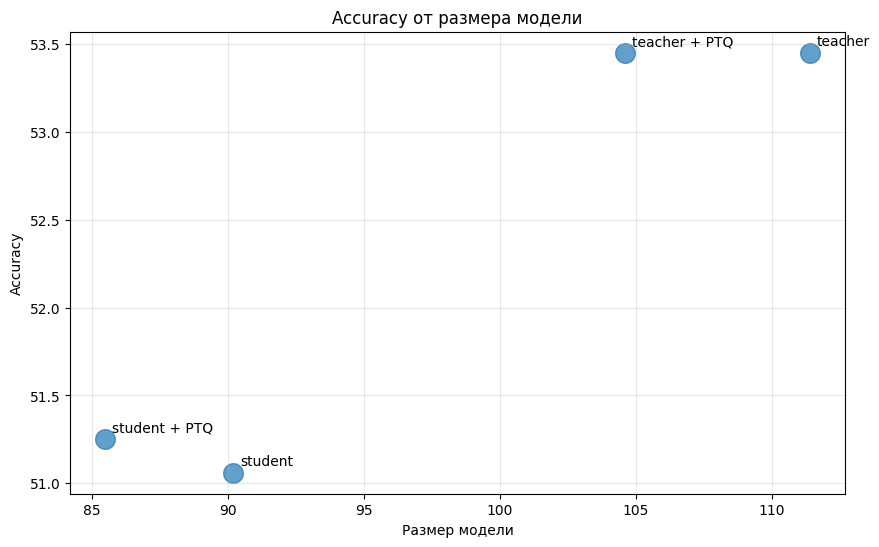

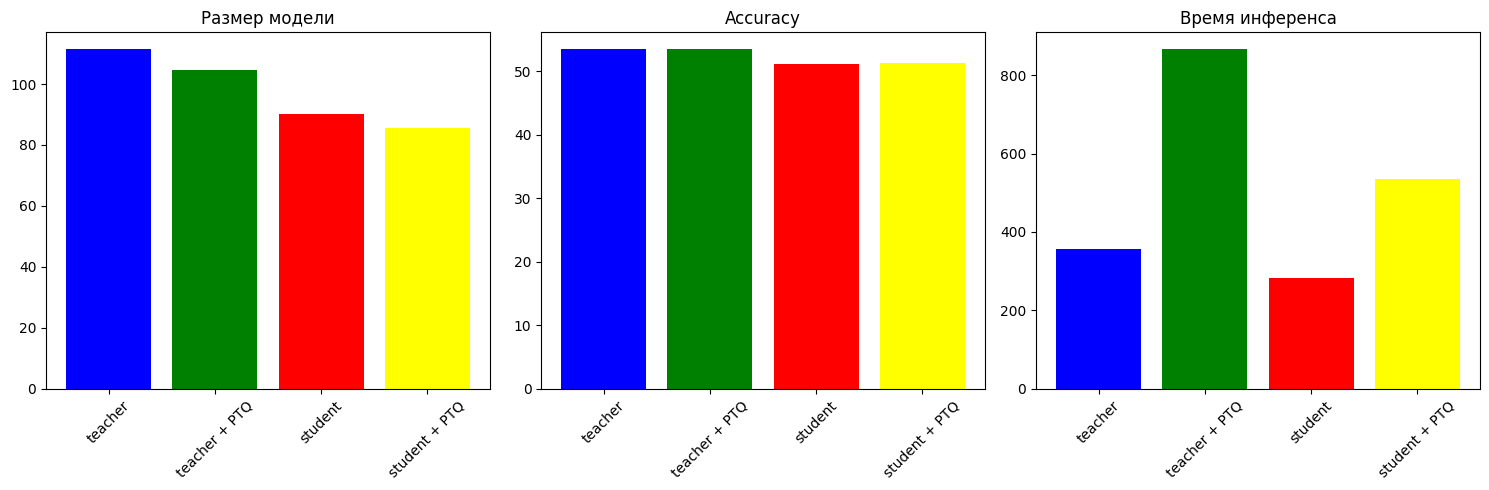

In [11]:
#Визуализация результатов

models = df_results['Модель'].tolist()
sizes = df_results['Размер'].tolist()
accuracies = df_results['Accuracy'].tolist()
speeds = df_results['Скорость'].tolist()

plt.figure(figsize=(10, 6))
plt.scatter(sizes, accuracies, s=200, alpha=0.7)

for i, model in enumerate(models):
    plt.annotate(model, (sizes[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Размер модели')
plt.ylabel('Accuracy')
plt.title('Accuracy от размера модели')
plt.grid(True, alpha=0.3)

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(models, sizes, color=['blue', 'green', 'red', 'yellow'])
axes[0].set_title('Размер модели')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(models, accuracies, color=['blue', 'green', 'red', 'yellow'])
axes[1].set_title('Accuracy')
axes[1].tick_params(axis='x', rotation=45)


axes[2].bar(models, speeds, color=['blue', 'green', 'red', 'yellow'])
axes[2].set_title('Время инференса')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()